In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

#catch nans
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx


from typing import Any, Callable, Union, Sequence


import matplotlib.pyplot as plt
from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

In [3]:
@jax.custom_vjp
def print_tangent(x):
    # This function will be used in the forward pass
    return x

def print_fwd(x):
    # Forward pass function for custom VJP
    return print_tangent(x), x

def print_bwd(x, g):
    # Backward pass function for custom VJP
    print(jtu.tree_flatten(g))
    print()
    
    return (g,)

print_tangent.defvjp(print_fwd, print_bwd)

In [4]:
@jax.custom_vjp
def normalize_grads(x):
    # This function will be used in the forward pass
    return x

def normalize_grads_fwd(x):
    # Forward pass function for custom VJP
    return normalize_grads(x), x

def normalize_grads_bwd(x, g):
    # Backward pass function for custom VJP
    
    #normalize gradients
    g = jtu.tree_map(lambda x: x / (np.linalg.norm(x)+1e-20), g)
    
    return (g,)

normalize_grads.defvjp(normalize_grads_fwd, normalize_grads_bwd)

In [5]:
@jax.custom_vjp
def clip_grads(x):
    # This function will be used in the forward pass
    return x

def clip_grads_fwd(x):
    # Forward pass function for custom VJP
    return clip_grads(x), x

def clip_grads_bwd(x, g):
    # Backward pass function for custom VJP
    
    #normalize gradients
    g = jtu.tree_map(lambda x: np.clip(x, -1e3, 1e3), g)
    
    return (g,)

clip_grads.defvjp(clip_grads_fwd, clip_grads_bwd)

In [6]:
@jax.custom_vjp
def discount_grads(x):
    # This function will be used in the forward pass
    return x

def discount_grads_fwd(x):
    # Forward pass function for custom VJP
    return discount_grads(x), x

def discount_grads_bwd(x, g):
    # Backward pass function for custom VJP
    
    #discount gradients
    g = jtu.tree_map(lambda x: x*.1, g)
    
    return (g,)

discount_grads.defvjp(discount_grads_fwd, discount_grads_bwd)

In [7]:
def differetiable_clip(x, x_min, x_max):
    return jax.nn.relu(x - x_max) + jax.nn.relu(x_min - x)

In [8]:
key = jax.random.PRNGKey(0)

# Cell State

In [9]:
class BaseCellState(eqx.Module):
    '''
    Module containing the basic features of a system state.

    '''

    # METHODS
    displacement:   jax_md.space.DisplacementFn = eqx.field(static=True)
    shift:          jax_md.space.ShiftFn = eqx.field(static=True)

    # STATE
    position:   jax.Array
    celltype:   jax.Array
    radius:     jax.Array
    division:   jax.Array


    @classmethod
    def empty(cls, n_dim=2, n_cell_types=1):

        '''
        Intializes a CellState with no cells (empty data structures, with correct shapes).

        Parameters
        ----------
        n_dim: int
            Number of spatial dimensions.

        '''

        assert n_dim == 2 or n_dim == 3, 'n_dim must be 2 or 3'

        disp, shift = jax_md.space.free()
        

        args = {
            'displacement'  :   disp,
            'shift'         :   shift,
            'position'  :   np.empty(shape=(0, n_dim), dtype=np.float32),
            'celltype'  :   np.empty(shape=(0,n_cell_types), dtype=np.float32),
            'radius'    :   np.empty(shape=(0,1), dtype=np.float32),
            'division'   :   np.empty(shape=(0,1), dtype=np.float32),
            }
        
        return cls(**args)


In [10]:
class CellState(BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array
    #mechanical_stress:  jax.Array


    @classmethod
    def empty(cls, n_dim=2, n_chem=1, hidden_size=10):

        a = BaseCellState.empty(n_dim).__dict__

        new_args = {
            'chemical' :   np.empty(shape=(0, n_chem), dtype=np.float32),
            'secretion_rate' :   np.empty(shape=(0, n_chem), dtype=np.float32),
            'chemical_grad' :   np.empty(shape=(0, int(n_dim*n_chem)), dtype=np.float32),
            'hidden_state' :   np.empty(shape=(0, hidden_size), dtype=np.float32),
            #'mechanical_stress' :  np.empty(shape=(0,1), dtype=np.float32),
            }
        
        a.update(new_args)

        return cls(**a)

# Environment

In [11]:
import abc

class SimulationStep(eqx.Module):

    @abc.abstractmethod
    def __call__(self, state, *, key=None, **kwargs):
        pass

    @abc.abstractmethod
    def return_logprob(self) -> bool:
        pass

## Cell division

**NOTE**: The whole Gumbel-Softmax is useless in this context. By formulating copy operations as multiplications autodiff is already able to deal with this situation. The gradient of the operation is just the copy matrix!

In [12]:
class CellDivisionReparam(SimulationStep):
    birth_radius_multiplier:    float
    softmax_T:                  float


    def return_logprob(self) -> bool:
        return False
    


    def __init__(self, *, birth_radius_multiplier=float(1/np.sqrt(2)), softmax_T=1., **kwargs):

        self.birth_radius_multiplier = birth_radius_multiplier
        self.softmax_T = softmax_T if softmax_T > 0. else 1e-3



    def _gumbel_logits_to_onehot(self, logits):

        onehot = jax.nn.one_hot(np.argmax(logits), logits.shape[-1])

        logits = jax.nn.softmax(logits)

        #straight through gradient
        zero = logits - jax.lax.stop_gradient(logits)

        return zero + jax.lax.stop_gradient(onehot)

        
    @jax.named_scope("jax_morph.CellDivisionReparam")
    def __call__(self, state, *, key=None, **kwargs):


        idx_new_cell = np.count_nonzero(state.celltype.sum(1))


        #split key
        subkey_div, subkey_place = jax.random.split(key,2)
        
        p = state.division
        p = p.squeeze() #remove "empty" dimensions -> (N,1) -> (N,)


        safe_p = np.where(p > 0., p, 1)
        logp = np.where(p > 0., np.log(safe_p), 0.)

        logits = (logp + jax.random.gumbel(subkey_div, shape=logp.shape))/self.softmax_T
        logits = np.where(p>0.,logits, -np.inf)
       
        # GUMBEL SOFTMAX STRAIGHT THROUGH step
        new_cell_contribs = self._gumbel_logits_to_onehot(logits)

        idx_dividing_cell = np.argmax(new_cell_contribs)


        division_matrix = np.eye(state.celltype.shape[0]).at[idx_new_cell].set(new_cell_contribs)

        state = jax.tree_map(lambda x: np.dot(division_matrix, x), state)


        #resize cell radii
        resize_rad = state.radius.at[idx_new_cell].set(state.radius[idx_new_cell]*self.birth_radius_multiplier)
        resize_rad = resize_rad.at[idx_dividing_cell].set(state.radius[idx_dividing_cell]*self.birth_radius_multiplier)

        state = eqx.tree_at(lambda s: s.radius, state, resize_rad)
        


        ### POSITION OF NEW CELLS
        angle = jax.random.uniform(subkey_place, minval=0., maxval=2*np.pi)

        cell_displacement = state.radius[idx_dividing_cell] * self.birth_radius_multiplier * np.array([np.cos(angle),np.sin(angle)])

        new_position = state.position.at[idx_new_cell].set(state.position[idx_dividing_cell]-cell_displacement)
        new_position = new_position.at[idx_dividing_cell].set(new_position[idx_dividing_cell]+cell_displacement)

        state = eqx.tree_at(lambda s: s.position, state, new_position)
    

        return state

In [13]:
class CellDivision(SimulationStep):
    birth_radius_multiplier:    float
    straight_through:           eqx.field(static=True)


    def return_logprob(self) -> bool:
        return not self.straight_through
    


    def __init__(self, *, birth_radius_multiplier=float(1/np.sqrt(2)), straight_through=False, **kwargs): 

        self.birth_radius_multiplier = birth_radius_multiplier
        self.straight_through = straight_through

        
    @jax.named_scope("jax_morph.CellDivisionReparam")
    def __call__(self, state, *, key=None, **kwargs):


        idx_new_cell = np.count_nonzero(state.celltype.sum(1))


        #split key
        subkey_div, subkey_place = jax.random.split(key,2)
        
        p = state.division.squeeze()
        p = p / p.sum()


        idx_dividing_cell = jax.random.choice(subkey_div, np.arange(p.shape[0]), p=p)

        onehot = jax.nn.one_hot(idx_dividing_cell, state.celltype.shape[0])

        if self.straight_through:
            new_cell_contribs = onehot + p - jax.lax.stop_gradient(p)
        else:
            new_cell_contribs = onehot


        division_matrix = np.eye(state.celltype.shape[0]).at[idx_new_cell].set(new_cell_contribs)

        state = jax.tree_map(lambda x: np.dot(division_matrix, x), state)


        #resize cell radii
        resize_rad = state.radius.at[idx_new_cell].set(state.radius[idx_new_cell]*self.birth_radius_multiplier)
        resize_rad = resize_rad.at[idx_dividing_cell].set(state.radius[idx_dividing_cell]*self.birth_radius_multiplier)

        state = eqx.tree_at(lambda s: s.radius, state, resize_rad)
        


        ### POSITION OF NEW CELLS
        angle = jax.random.uniform(subkey_place, minval=0., maxval=2*np.pi)

        cell_displacement = state.radius[idx_dividing_cell] * self.birth_radius_multiplier * np.array([np.cos(angle),np.sin(angle)])

        new_position = state.position.at[idx_new_cell].set(state.position[idx_dividing_cell]-cell_displacement)
        new_position = new_position.at[idx_dividing_cell].set(new_position[idx_dividing_cell]+cell_displacement)

        state = eqx.tree_at(lambda s: s.position, state, new_position)
    
        if self.straight_through:
            return state
        else:
            return state, np.log(p[idx_dividing_cell])

## Cell growth

In [14]:
class CellGrowth(SimulationStep):
    max_radius:     float
    growth_rate:    float
    growth_type:    str = eqx.field(static=True)


    def return_logprob(self) -> bool:
        return False
    
    
    def __init__(self, *, 
                 growth_rate=1., 
                 max_radius=.5, 
                 growth_type='linear',
                 **kwargs
                 ):

        # if not hasattr(state, 'radius'):
        #     raise AttributeError('CellState must have "radius" attribute')
        
        if growth_type not in ['linear', 'exponential']:
            raise ValueError('growth_type must be either "linear" or "exponential"')
        
        self.growth_rate = growth_rate
        self.max_radius = max_radius
        self.growth_type = growth_type



    @jax.named_scope("jax_morph.CellGrowth")
    def __call__(self, state, *, key=None, **kwargs):

        if self.growth_type == 'linear':
            new_radius = state.radius + self.growth_rate
        elif self.growth_type == 'exponential':
            new_radius = state.radius*np.exp(self.growth_rate)

        new_radius = np.where(new_radius > self.max_radius, self.max_radius, new_radius)*np.where(state.celltype.sum(1)[:,None]>0, 1, 0)

        state = eqx.tree_at(lambda s: s.radius, state, new_radius)

        return state

## Mechanical

In [15]:
class SGDMechanicalRelaxation(SimulationStep):
    mechanical_potential:   eqx.Module
    relaxation_steps:       int = eqx.field(default=25, static=True)
    dt:                     float = eqx.field(default=8e-4, static=True)


    def return_logprob(self) -> bool:
        return False


    def _sgd(self, state, pair_potential):

        init, apply = jax_md.minimize.gradient_descent(pair_potential, state.shift, self.dt) 
 
        def scan_fn(opt_state, i):
            return apply(opt_state), 0.

        #relax system
        opt_state = init(state.position)
        opt_state, _ = jax.lax.scan(scan_fn, opt_state, np.arange(self.relaxation_steps))

        return opt_state
    
    
    @jax.named_scope("jax_morph.SGDMechanicalRelaxation")
    def __call__(self, state, *, key=None, **kwargs):

        #generate morse pair potential
        energy_fn = self.mechanical_potential.energy_fn(state)
        
        #minimize
        new_positions = self._sgd(state, energy_fn)

        state = eqx.tree_at(lambda s: s.position, state, new_positions)

        return state

In [16]:
#Define Potential ABC
class MechanicalInteractionPotential(eqx.Module):

    @abc.abstractmethod
    def energy_fn(self, state, *, per_particle):
        pass


class MorsePotential(MechanicalInteractionPotential):
    epsilon:   Union[float, jax.Array] = 3.
    alpha:     float = 2.8
    r_cutoff:  float = eqx.field(default=2., static=True)
    r_onset:   float = eqx.field(default=1.7, static=True)


    def _calculate_epsilon_matrix(self, state):

        if np.atleast_1d(self.epsilon).size == 1:
            alive = np.where(state.celltype.sum(1) > 0, 1, 0)
            epsilon_matrix = (np.outer(alive, alive)-np.eye(alive.shape[0]))*self.epsilon


        elif isinstance(self.epsilon, jax.interpreters.xla.DeviceArray):
            
            ### implement general logic for multiple cell types
            raise NotImplementedError('Multiple cell types not implemented yet')


        return epsilon_matrix
    

    def _calculate_sigma_matrix(self, state):

        # sigma_matrix = state.radius[:,None] + state.radius[None,:]

        # In principle this should be the right expression:
        # alive = np.where(state.celltype.sum(1) > 0, 1, 0)
        # sigma_matrix = (state.radius + state.radius.T - 2*np.diag(test_state.radius.squeeze()))*np.outer(alive, alive)
        
        # BUT since we already put epsilon = 0 for non-interacting cells, we can save on some operations

        sigma_matrix = state.radius + state.radius.T

        return sigma_matrix
    

    def energy_fn(self, state, *, per_particle=False):

        epsilon_matrix = self._calculate_epsilon_matrix(state)
        sigma_matrix = self._calculate_sigma_matrix(state)

        #generate morse pair potential
        morse_energy = jax_md.energy.morse_pair(state.displacement,
                                                alpha=self.alpha,
                                                epsilon=epsilon_matrix,
                                                sigma=sigma_matrix, 
                                                r_onset=self.r_onset, 
                                                r_cutoff=self.r_cutoff,
                                                per_particle=per_particle
                                                )
        
        return morse_energy


## Diffusion

In [17]:
class SteadyStateDiffusion(SimulationStep):
    diffusion_coeff:    Union[float, jax.Array]
    degradation_rate:   Union[float, jax.Array]
    _vmap_diff_inaxes:  tuple = eqx.field(static=True)


    def return_logprob(self) -> bool:
        return False
    

    def __init__(self, *, diffusion_coeff=2., degradation_rate=1., **kwargs):

        self.diffusion_coeff = diffusion_coeff
        self.degradation_rate = degradation_rate

        _inaxes_diffcoef = 0 if np.atleast_1d(self.diffusion_coeff).size > 1 else None
        _inaxes_degrate = 0 if np.atleast_1d(self.degradation_rate).size > 1 else None
        self._vmap_diff_inaxes = (1, _inaxes_diffcoef, _inaxes_degrate, None)


    @jax.named_scope("jax_morph.SteadyStateDiffusion")
    def __call__(self, state, *, key=None, **kwargs):


        #calculate all pairwise distances
        dist = jax_md.space.map_product(jax_md.space.metric(state.displacement))(state.position, state.position)

        alive = np.where(state.celltype.sum(1) > 0, 1, 0)
        alive = np.outer(alive, alive)

        # -----------------------------------------
        ### OLD APPROACH:
        ### Dense adjacency matrix like 1/distance

        # #zero out connections to inexistent cells
        # dist = dist*alive

        # #prevent division by zero
        # safe_dist = np.where(dist>0, dist, 1)

        # #adjacency matrix
        # A = np.where(dist>0., 1/safe_dist, 0)#**2

        # #graph laplacian
        # L = np.diag(np.sum(A, axis=0)) - A

        # -----------------------------------------


        #connect only cells that are nearest neighbors
        nn_dist = state.radius + state.radius.T * alive
        A = np.where(dist < 1.1*nn_dist, 1, 0) * (1-np.eye(dist.shape[0])) * alive

        # OPEN BOUNDARY CONDITIONS (1)
        # AWFUL approximation to open boundary conditions
        # Fails miserably if there is no bulk and all cells are connected to the boundary
        # diag = np.sum(A, axis=0).max() * np.eye(A.shape[0]) * alive

        # OPEN BOUNDARY CONDITIONS (2)
        # ALTERNATIVE approx: boundary nodes are the ones that have at least 2 neighbors less than the maximally connected node
        # NOTE: fails to capture early stages of growth, when all cells are on the boundary
        # diag = np.sum(A, axis=0)
        # diag = np.where(diag-diag.max() < -2, diag+1, diag)
        # diag = np.where(np.sum(A, axis=0) > 0, diag, 0)
        # diag = np.diag(diag)


        # OPEN BOUNDARY CONDITIONS (3)
        # YET ANOTHER APPROX: Heuristically bulk nodes have at least 5 neighbors.
        # Hence any node with less than 5 neighbors is a boundary node
        # VERY HEURISTIC but fixes the early growth problem
        diag = np.sum(A, axis=0)
        diag = np.where(diag < 5, diag+1, diag)
        diag = np.where(np.sum(A, axis=0) > 0, diag, 0)
        diag = np.diag(diag)


        #graph laplacian
        L = diag - A
    

        def _ss_chemfield(P, D, K, L):

            #update laplacian with degradation
            L = D*L + K*np.eye(L.shape[0])

            #solve for steady state
            c = np.linalg.solve(L, P)

            return c
        
        
        #calculate steady state chemical field
        _ss_chemfield = jax.vmap(_ss_chemfield, in_axes=self._vmap_diff_inaxes, out_axes=1)

        new_chem = _ss_chemfield(state.secretion_rate, self.diffusion_coeff, self.degradation_rate, L)


        #update chemical field
        state = eqx.tree_at(lambda s: s.chemical, state, new_chem)

        return state

# Cell internals

## Chemical gradients

In [18]:
class LocalChemicalGradients(SimulationStep):
    neighbor_radius:    Union[float,None] = eqx.field(static=True)


    def return_logprob(self) -> bool:
        return False


    def __init__(self, *, neighbor_radius=None, **kwargs):

        self.neighbor_radius = neighbor_radius


    @jax.named_scope("jax_morph.LocalChemicalGradients")
    def __call__(self, state, *, key=None, **kwargs):

        # mask only cells that exist
        c_alive = state.celltype.sum(1)>0.
        c_alive = np.outer(c_alive, c_alive)

        # displacements between cell pairs (ncells x ncells x ndim_space)
        disp = jax.vmap(jax.vmap(state.displacement, in_axes=[0,None]), in_axes=[None,0])(state.position, state.position)

        # distances btw cell pairs
        dist = (disp**2).sum(2)

        # avoid division by zero in gradient calculation
        safe_dist = np.where(dist>0., dist, 1)
        dist = np.where(dist>0., safe_dist, 0)

        # dist w/ non-existing cells are zeroed out
        dist *= c_alive

        #jax.debug.print('{x}', x=(disp**2).sum(2))

        # consider as neigbors:
        # - cells less than one radius away (+ small tolerance)
        # - cells differents from themselves
        # - cells that exist
        if None == self.neighbor_radius:
            # "touching" distance betw. cells
            R = (state.radius+state.radius.T)*c_alive
        else:
            R = (self.neighbor_radius)*c_alive
        
        neig = (dist<R)*(dist>0.)

        #safe_dist = np.where(dist>0, dist, 1)

        # normalize all displacements
        norm_disp = (disp*neig[:,:,None])/(dist[:,:,None]+1e-8)
        norm_disp = np.where((dist>0)[:,:,None], (disp*neig[:,:,None])/safe_dist[:,:,None], 0)

        # calculates x and y components of grad for single chemical
        def _grad_chem(chem):
            return (norm_disp*chem.ravel()[:,None]).sum(1)
            

        #vectorize over chemicals
        #OUTPUT SHAPE: ncells x ndim x nchem
        _grad_chem = jax.vmap(_grad_chem, in_axes=1, out_axes=2)

        #calc grads (no non-existing cells or lone cells w/ no neighbors)
        chemgrads = _grad_chem(state.chemical)
            
        # transform into ncells x (grad_x + grad_y)
        #reshape like ncells x ndim x nchem to revert
        chemgrads = chemgrads.reshape(state.celltype.shape[0], -1)

        #update state
        state = eqx.tree_at(lambda s: s.chemical_grad, state, chemgrads)

        return state

## Mechanical stress

In [19]:
class LocalMechanicalStress(SimulationStep):
    mechanical_potential:       eqx.Module


    def return_logprob(self) -> bool:
        return False


    def __init__(self, mechanical_potential, **kwargs):
        self.mechanical_potential = mechanical_potential

    
    @jax.named_scope("jax_morph.LocalMechanicalStress")
    def __call__(self, state, *, key=None, **kwargs):

        #generate pair potential
        pair_potential = self.mechanical_potential.energy_fn(state)
        
        forces = jax.jacrev(pair_potential)(state.position)
        
        # F_ij = force on i by j, r_ij = displacement from i to j
        drs = jax_md.space.map_product(state.displacement)(state.position, state.position)
        
        stresses = np.sum(np.multiply(forces, np.sign(drs)), axis=(0, 2))[:,None]
        stresses = np.where(state.celltype.sum(1)[:,None] > 0, stresses, 0.)

        state = eqx.tree_at(lambda s: s.mechanical_stress, state, stresses)

        return state

## Division Rates

In [20]:
class DivisionMLP(SimulationStep):
    input_fields:        Sequence[str] = eqx.field(static=True)
    transform_output:    Union[Callable,None] = eqx.field(static=True)
    mlp:                 eqx.nn.MLP


    def return_logprob(self) -> bool:
        return False


    def __init__(self, state, 
                 input_fields, 
                 *,
                 key,
                 w_init=jax.nn.initializers.constant(0.),
                 transform_output=None,
                 final_activation=jax.nn.softplus,
                 **kwargs
                 ):

        self.transform_output = transform_output
        self.input_fields = input_fields

        in_shape = np.concatenate([getattr(state, field) for field in input_fields], axis=1).shape[-1]
        out_shape = 1

        self.mlp = eqx.nn.MLP(in_size=in_shape,
                            out_size=out_shape,
                            depth=0,
                            width_size=0,
                            activation=jax.nn.leaky_relu,
                            final_activation=final_activation,
                            key=key,
                            **kwargs
                            )
        
        self.mlp = eqx.tree_at(lambda m: m.layers[0].weight, self.mlp, w_init(key, self.mlp.layers[0].weight.shape))


    @jax.named_scope("jax_morph.DivisionMLP")
    def __call__(self, state, *, key=None, **kwargs):

        #concatenate input features
        in_features = np.concatenate([getattr(state, field) for field in self.input_fields], axis=1)


        #apply MLP
        division = jax.vmap(self.mlp)(in_features)


        #transform output
        if self.transform_output is not None:
            division = self.transform_output(state, division)
        

        #keep only alive cells
        division = np.where(state.celltype.sum(1)[:,None] > 0, division, 0.)

        #update state
        state = eqx.tree_at(lambda s: s.division, state, division)

        return state    

## Secretion Rates

In [21]:
class SecretionMLP(SimulationStep):
    input_fields:        Sequence[str] = eqx.field(static=True)
    transform_output:    Union[Callable,None] = eqx.field(static=True)
    ctype_sec_chem:      eqx.field(static=True)
    mlp:                 eqx.nn.MLP


    def return_logprob(self) -> bool:
        return False


    def __init__(self, 
                state, 
                input_fields,
                *,
                key,
                ctype_sec_chem=None,
                w_init=jax.nn.initializers.orthogonal(),
                transform_output=None,
                final_activation=lambda x: jax.nn.sigmoid(x/10.),
                **kwargs
                ):

        self.transform_output = transform_output
        self.input_fields = input_fields

        in_shape = np.concatenate([getattr(state, field) for field in input_fields], axis=1).shape[1]
        out_shape = state.chemical.shape[-1]

        self.mlp = eqx.nn.MLP(in_size=in_shape,
                            out_size=out_shape,
                            depth=0,
                            width_size=0,
                            activation=jax.nn.leaky_relu,
                            final_activation=final_activation,
                            key=key,
                            **kwargs
                            )
        
        self.mlp = eqx.tree_at(lambda m: m.layers[0].weight, self.mlp, w_init(key, self.mlp.layers[0].weight.shape))


        if ctype_sec_chem is None:
            self.ctype_sec_chem = [1.]*state.chemical.shape[1]
        else:
            self.ctype_sec_chem = ctype_sec_chem



    @jax.named_scope("jax_morph.SecretionMLP")
    def __call__(self, state, *, key=None, **kwargs):

        #concatenate input features
        in_features = np.concatenate([getattr(state, field) for field in self.input_fields], axis=1)


        #apply MLP
        secretion_rate = jax.vmap(self.mlp)(in_features)

        #transform output
        if self.transform_output is not None:
            secretion_rate = self.transform_output(state, secretion_rate)


        sec_mask = state.celltype @ np.atleast_2d(self.ctype_sec_chem)

        secretion_rate = sec_mask*secretion_rate


        #update state
        state = eqx.tree_at(lambda s: s.secretion_rate, state, secretion_rate)

        return state

## Hidden State

In [22]:
class HiddenStateMLP(SimulationStep):
    input_fields:        Sequence[str] = eqx.field(static=True)
    transform_output:    Union[Callable,None] = eqx.field(static=True)
    mlp:                 eqx.nn.MLP
    memory_decay:        Union[float, jax.Array]


    def return_logprob(self) -> bool:
        return False


    def __init__(self, 
                state, 
                input_fields,
                *,
                key,
                layer_width=128,
                num_mlp_hidden_layers=1,
                memory_decay=.7,
                transform_output=None,
                final_activation=lambda x: x,
                **kwargs
                ):

        self.memory_decay = memory_decay
        self.transform_output = transform_output
        self.input_fields = input_fields

        in_shape = np.concatenate([getattr(state, field) for field in input_fields], axis=1).shape[-1]
        out_shape = state.hidden_state.shape[1]

        self.mlp = eqx.nn.MLP(in_size=in_shape,
                            out_size=out_shape,
                            depth=int(num_mlp_hidden_layers+1),
                            width_size=int(layer_width),
                            activation=jax.nn.leaky_relu,
                            final_activation=final_activation,
                            key=key,
                            **kwargs
                            )
        
        #self.mlp = eqx.tree_at(lambda m: m.layers[0].weight, self.mlp, w_init(key, self.mlp.layers[0].weight.shape))



    @jax.named_scope("jax_morph.HiddenStateMLP")
    def __call__(self, state, *, key=None, **kwargs):

        #concatenate input features
        in_features = np.concatenate([getattr(state, field) for field in self.input_fields], axis=1)

        #apply MLP
        delta_hs = jax.vmap(self.mlp)(in_features)


        #transform output
        if self.transform_output is not None:
            delta_hs = self.transform_output(state, delta_hs)

        #keep only alive cells
        delta_hs = np.where(state.celltype.sum(1)[:,None] > 0, delta_hs, 0.)

        hidden_state = self.memory_decay*state.hidden_state + (1-self.memory_decay)*delta_hs

        #update state
        state = eqx.tree_at(lambda s: s.hidden_state, state, hidden_state)

        return state

## Gene Network

In [342]:
class GeneNetwork(SimulationStep):
    input_fields:        Sequence[str] = eqx.field(static=True)
    output_fields:       Sequence[str] = eqx.field(static=True)
    out_indices:         tuple = eqx.field(static=True)
    transform_output:    Union[Callable,None] = eqx.field(static=True)
    n_solver_steps:      int = eqx.field(static=True)
    dt:                  float = eqx.field(static=True)

    interaction_matrix:  jax.Array
    degradation_rate:    Union[float, jax.Array]
    expr_level_decay:    Union[float, jax.Array]


    def return_logprob(self) -> bool:
        return False
    

    def circuit_solve(self, x0, I):
    
        def _step(xt,t):
            xtt = xt + self.x_dot(xt,I)*self.dt
            return xtt, 0.

        x, _ = jax.lax.scan(_step, x0, np.arange(self.n_solver_steps))
        
        return x
    

    def x_dot(self, xt, I):
        return jax.nn.sigmoid(xt @ self.interaction_matrix) - self.degradation_rate * xt + I



    def __init__(self, 
                state, 
                input_fields,
                output_fields,
                *,
                key,
                expr_level_decay=.7,
                interaction_init=jax.nn.initializers.normal(1.),
                degradation_init=jax.nn.initializers.constant(1.),
                transform_output=None,
                n_solver_steps=int(1e2),
                dt=.1,
                **kwargs
                ):
        


        self.input_fields = input_fields
        self.output_fields = output_fields
        self.expr_level_decay = float(expr_level_decay)

        self.n_solver_steps = int(n_solver_steps)
        self.dt = dt

        in_shape = np.concatenate([getattr(state, field) for field in input_fields], axis=1).shape[-1]
        out_shape = np.concatenate([getattr(state, field) for field in output_fields], axis=1).shape[-1]

        system_size = int(in_shape + state.hidden_state.shape[-1] + out_shape)

        self.interaction_matrix = interaction_init(key, shape=(system_size, system_size))
        self.degradation_rate = degradation_init(key, shape=(1, system_size))

        out_sizes = [getattr(state, field).shape[-1] for field in self.output_fields]
        self.out_indices = tuple((system_size - np.cumsum(np.asarray(out_sizes)[::-1])).tolist()[::-1] + [system_size])

        
        if transform_output is None:
            self.transform_output = None
        else:
            self.transform_output = dict(zip(self.output_fields, [None]*len(self.output_fields)))
            self.transform_output.update(transform_output)



    @jax.named_scope("jax_morph.GeneNetwork")
    def __call__(self, state, *, key=None, **kwargs):

        #concatenate input features
        in_features = np.concatenate([getattr(state, field) for field in self.input_fields], axis=1)
        out_features = np.concatenate([getattr(state, field) for field in self.output_fields], axis=1)

        gene_state = np.concatenate([in_features, self.expr_level_decay*state.hidden_state, out_features], axis=1)
        I = np.concatenate([in_features, np.zeros_like(state.hidden_state), np.zeros_like(out_features)], axis=1)

        alive = np.where(state.celltype.sum(1)>0., 1., 0.)[:,None]

        gene_state = self.circuit_solve(gene_state, I) * alive

        hidden_state = gene_state[:, in_features.shape[-1]:in_features.shape[-1]+state.hidden_state.shape[-1]]

        #update state
        state = eqx.tree_at(lambda s: s.hidden_state, state, hidden_state)

        #update output
        for i, field in enumerate(self.output_fields):

            new_field = gene_state[:, self.out_indices[i]:self.out_indices[i+1]]

            if self.transform_output[field] is not None:
                new_field = self.transform_output[field](state, new_field) * alive

            state = eqx.tree_at(lambda s: getattr(s, field), state, new_field)

        return state

# Simulation

In [333]:
class Sequential(SimulationStep):
    substeps: tuple
    _return_logp: bool = eqx.field(static=True)


    def return_logprob(self) -> bool:
        return self._return_logp



    def __init__(self, substeps: Sequence[Callable]):

        if all(isinstance(x, SimulationStep) for x in substeps):
            self.substeps = tuple(substeps)
        else:
            raise TypeError("All substeps must be of type `SimulationStep`")
        
        self._return_logp = any(x.return_logprob() for x in self.substeps)
        


    @jax.named_scope("jax_morph.Sequential")
    def __call__(self, state, *, key=None, **kwargs):


        if key is None:
            keys = [None] * len(self.substeps)
        else:
            keys = jax.random.split(key, len(self.substeps))


        logp = np.float_(0.)

        for substep, key in zip(self.substeps, keys):

            if substep.return_logprob():
                state, logp = substep(state, key=key)
                logp += logp
            else:
                state = substep(state, key=key)


        if self._return_logp:
            return state, logp
        else:
            return state
        



    def __getitem__(self, i: Union[int, slice]) -> Callable:
        if isinstance(i, int):
            return self.substeps[i]
        elif isinstance(i, slice):
            return Sequential(self.substeps[i])
        else:
            raise TypeError(f"Indexing with type {type(i)} is not supported")

    def __iter__(self):
        yield from self.substeps

    def __len__(self):
        return len(self.substeps)

# Tests

## Model and loss

In [ ]:
# class RelaxAndStress(eqx.Module):
#     shared:     eqx.Module

#     def __init__(self, relax, stress, **kwargs):
        
#         where = lambda x: x[1].mechanical_potential
#         get = lambda x: x[0].mechanical_potential

#         self.shared = eqx.nn.Shared((relax, stress), where, get)


#     def __call__(self, state, *, key=None):

#         relax, stress = self.shared()

#         state = relax(state, key=key)
#         state = stress(state, key=key)

#         return state


# RelaxAndStress(
    # relax=SGDMechanicalRelaxation(mech_potential),
    # stress=LocalMechanicalStress(mech_potential)
# )

In [ ]:
key, subkey = jax.random.split(key)

In [ ]:
disp, shift = jax_md.space.free()

N_DIM = 2
N = 100
N_ADD = int(N-1)

N_CHEM = 2
N_HIDDEN = 8


istate = CellState(
    displacement=disp,
    shift=shift,
    position=np.zeros(shape=(N,N_DIM)),
    celltype=np.zeros(shape=(N,1)).at[0].set(1),
    radius=np.zeros(shape=(N,1)).at[0].set(.5),
    division=np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=np.zeros(shape=(N,N_CHEM)),
    chemical_grad=np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate=np.zeros(shape=(N,N_CHEM)).at[0].set(1.), 
    hidden_state=np.zeros(shape=(N,N_HIDDEN)).at[0].set(jax.random.uniform(subkey, shape=(N_HIDDEN,))), #
)

In [ ]:
mech_potential = MorsePotential(epsilon=3., alpha=2.8)



model = eqx.nn.Sequential(
    layers=[
        CellDivisionReparam(softmax_T=.1), #the higher softmax_T, the more mechanical relaxation steps are needed for stable relaxation

        CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        SGDMechanicalRelaxation(mech_potential, relaxation_steps=50, dt=1e-3),

        SteadyStateDiffusion(degradation_rate=.001, diffusion_coeff=np.asarray([1.,2.])),

        LocalChemicalGradients(),


        HiddenStateMLP(istate, input_fields=['chemical'], key=key, layer_width=32),

        SecretionMLP(istate, input_fields=['hidden_state'], key=key),
        
        DivisionMLP(istate, input_fields=['hidden_state'], key=key),
    ])




@eqx.filter_jit
def loss(model, state, key, n_steps=1):
    
    # for i in range(n_steps):
    #     key, subkey = jax.random.split(key)
    #     state = model(state, key=subkey)
    #     state = normalize_grads(state)

    subkeys = jax.random.split(key, n_steps)

    def _scan_fn(state, k):

        state = model(state, key=k)
        #state = normalize_grads(state)

        return state, state
    
    state, _ = jax.lax.scan(_scan_fn, state, np.asarray(subkeys))

    return (state.position[:,1]**2).sum(), state

In [ ]:
#g, s = eqx.filter_grad(loss, has_aux=True)(model, istate, subkey, N_ADD)

In [ ]:
key, subkey = jax.random.split(key)

In [ ]:
l,s = loss(model, istate, subkey, N_ADD)

In [ ]:
l

Array(499.39549033, dtype=float64)

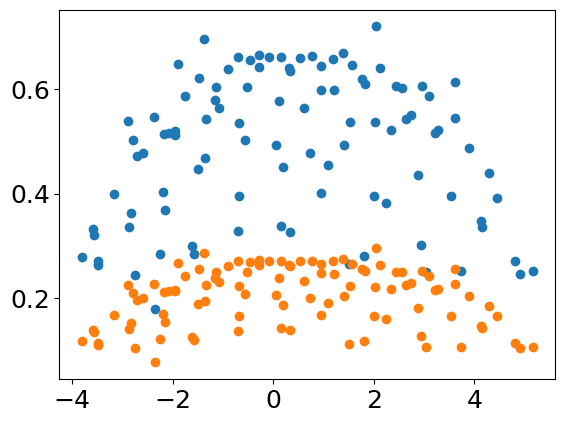

In [ ]:
plt.scatter(s.position[:,0], s.chemical[:,0])
plt.scatter(s.position[:,0], s.chemical[:,1])

In [ ]:
# jtu.tree_flatten(g)

In [ ]:
# jtu.tree_flatten(jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g))

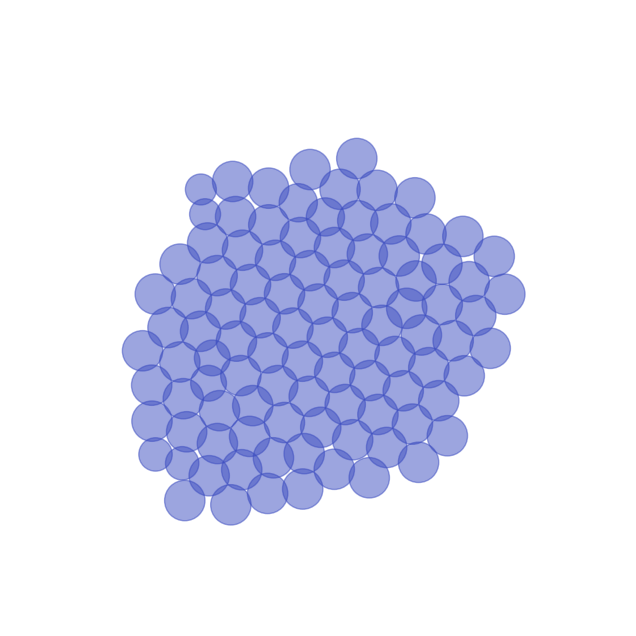

In [ ]:
draw_circles_ctype(s);

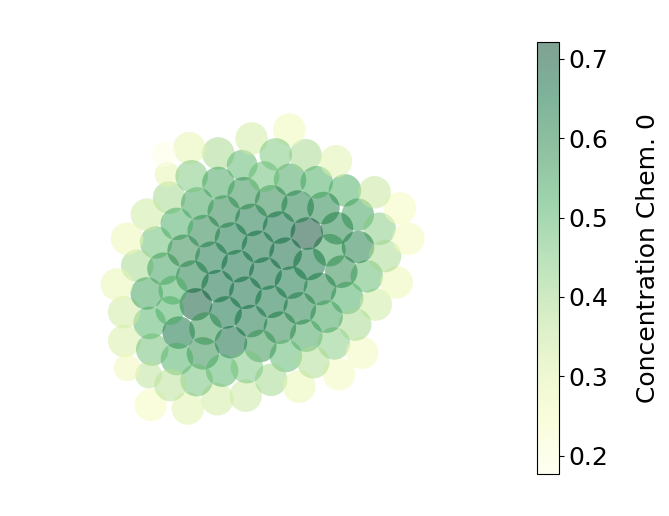

In [ ]:
draw_circles_chem(s, 0);

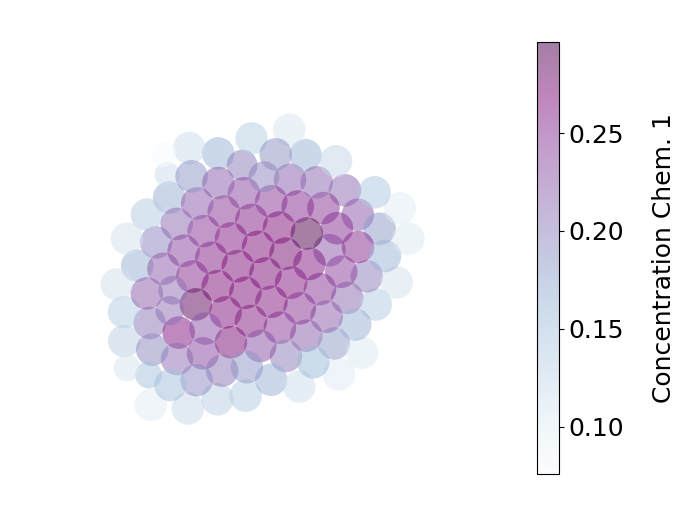

In [ ]:
draw_circles_chem(s, 1);

## Optimization (Path estimation)

In [ ]:
import optax
from tqdm import trange

from functools import partial

In [ ]:
key, subkey = jax.random.split(key)

In [ ]:
disp, shift = jax_md.space.free()

N_DIM = 2
N = 50
N_ADD = int(N-1)

N_CHEM = 2
N_HIDDEN = 8


istate = CellState(
    displacement=disp,
    shift=shift,
    position=np.zeros(shape=(N,N_DIM)),
    celltype=np.zeros(shape=(N,1)).at[0].set(1),
    radius=np.zeros(shape=(N,1)).at[0].set(.5),
    division=np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=np.zeros(shape=(N,N_CHEM)),
    chemical_grad=np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate=np.zeros(shape=(N,N_CHEM)).at[0].set(1.), 
    hidden_state=np.zeros(shape=(N,N_HIDDEN)).at[0].set(jax.random.uniform(subkey, shape=(N_HIDDEN,))), #
)

In [ ]:
@eqx.filter_jit
def simulate(model, state, key, n_steps=1):

    subkeys = jax.random.split(key, n_steps)

    def _scan_fn(state, k):
        state = model(state, key=k)
        state = normalize_grads(state)
        return state, state
    
    state, history = jax.lax.scan(_scan_fn, state, np.asarray(subkeys))

    return state



@eqx.filter_jit
def loss(model, state, key, n_steps=1):

    state = jax.vmap(simulate, in_axes=(None,None,0,None))(model, istate, np.atleast_2d(key), n_steps)

    #separate arrays
    # penalty = eqx.filter(model, eqx.is_array)

    # l2 norm of model numpy arrays
    # penalty = jtu.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: np.linalg.norm(x), penalty))


    # return ((state.chemical[:,:,0]-jax.lax.stop_gradient(np.exp(state.position[:,:,0])))**2).mean() #+ ((state.chemical[:,:,1]-jax.lax.stop_gradient(np.exp(state.position[:,:,1])))**2).mean()
    return (state.position[:,:,1]**2).mean() #+ penalty
    # return ((state.division[:,:,0]-jax.lax.stop_gradient(np.exp(state.position[:,:,0])))**2).mean()


In [ ]:
key, init_key = jax.random.split(key)


mech_potential = MorsePotential(epsilon=3., alpha=2.8)

model = eqx.nn.Sequential(
    layers=[
        # CellDivisionReparam(softmax_T=1.), #the higher softmax_T, the more mechanical relaxation steps are needed for stable relaxation
        CellDivision(straight_through=True),

        CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        SGDMechanicalRelaxation(mech_potential),

        SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=np.array([.5, .2])),

        LocalChemicalGradients(),

        # ['chemical','chemical_grad']
        HiddenStateMLP(istate, 
                       input_fields=['chemical','chemical_grad'], 
                       key=init_key, 
                       layer_width=32, 
                       num_mlp_hidden_layers=4,
                       memory_decay=.7,
                    #    transform_output=lambda s,x: jax.nn.tanh(x),
                       ),

        SecretionMLP(istate, input_fields=['hidden_state'], key=init_key),
        
        DivisionMLP(istate, input_fields=['hidden_state'], key=init_key),
    ])


In [ ]:
BATCH_SIZE = 2
EPOCHS = 100

optimizer = optax.adam(1e-3)
# optimizer = optax.chain(
#     #optax.add_decayed_weights(1.),
#     optax.clip_by_global_norm(1.),
#     optax.adam(1e-3),
#     )

opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

key, *subkeys = jax.random.split(key, BATCH_SIZE+1)
l, g = eqx.filter_value_and_grad(loss)(model, istate, subkeys, N_ADD)

losses = [float(l)]

pbar = trange(EPOCHS)
for e in pbar:

    # g = jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g)

    # if e+1 % 50 == 0:
    #     model = eqx.tree_at(lambda m: m.layers[0].softmax_T, model, model.layers[0].softmax_T*0.5)

    updates, opt_state = optimizer.update(g, opt_state, model)
    model = eqx.apply_updates(model, updates)

    key, *subkeys = jax.random.split(key, BATCH_SIZE+1)
    l, g = eqx.filter_value_and_grad(loss)(model, istate, subkeys, N_ADD)

    losses.append(float(l))
    pbar.set_description(f'Loss: {l:.3f}')

Loss: 2.554: 100%|████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


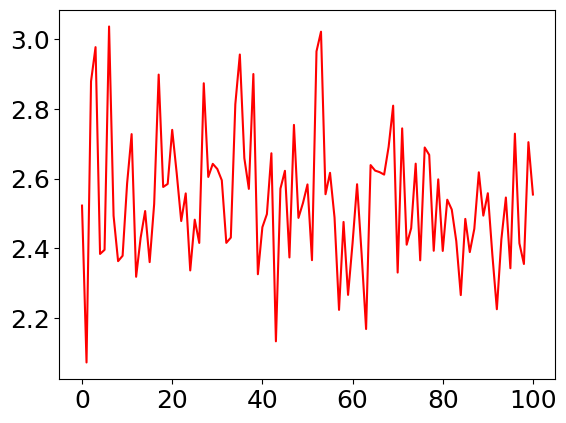

In [ ]:
plt.plot(losses, 'r')

#plt.yscale('log')

In [ ]:
s = simulate(model, istate, subkey, N_ADD)

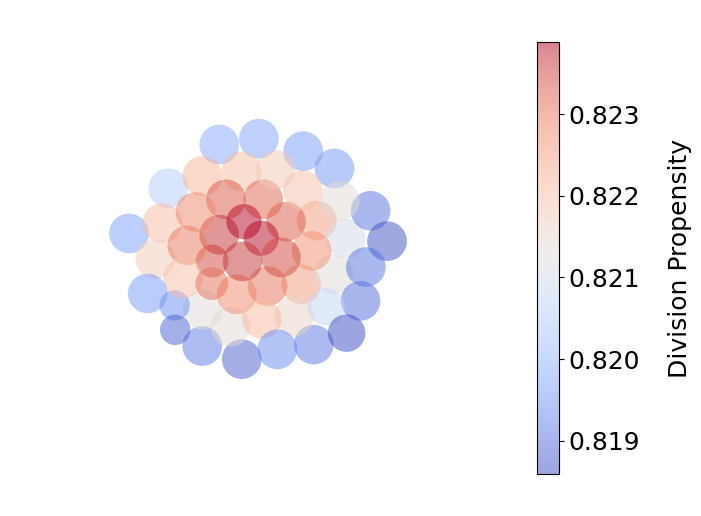

In [ ]:
draw_circles_divrate(s);

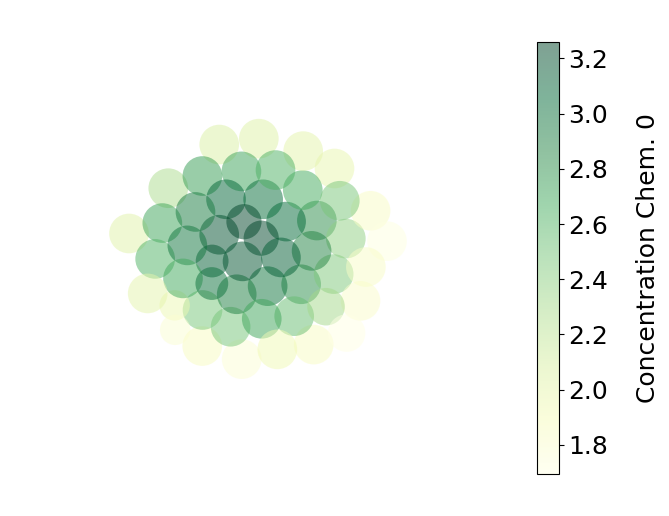

In [ ]:
draw_circles_chem(s, 0);

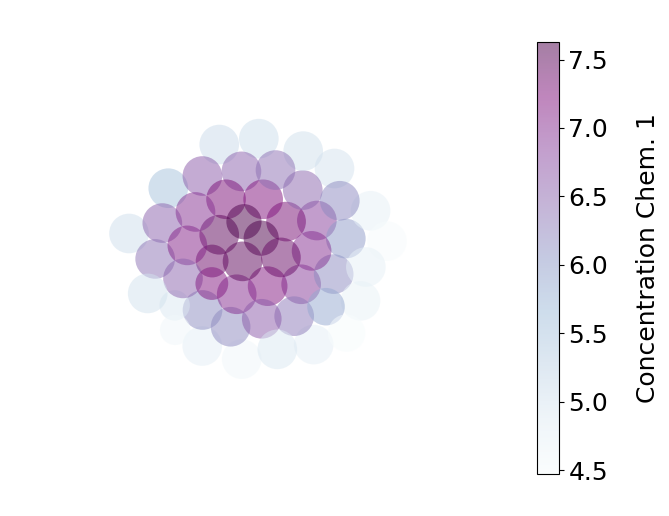

In [ ]:
draw_circles_chem(s, 1);

## Optimization (REINFORCE)

In [25]:
import optax
from tqdm import trange

from functools import partial

In [26]:
key, subkey = jax.random.split(key)

In [412]:
disp, shift = jax_md.space.free()

N_DIM = 2
N = 80
N_ADD = int(N-1)

N_CHEM = 5
N_HIDDEN = 32


istate = CellState(
    displacement=disp,
    shift=shift,
    position=np.zeros(shape=(N,N_DIM)),
    celltype=np.zeros(shape=(N,1)).at[0].set(1),
    radius=np.zeros(shape=(N,1)).at[0].set(.5),
    division=np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=np.zeros(shape=(N,N_CHEM)),
    chemical_grad=np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate=np.zeros(shape=(N,N_CHEM)).at[0].set(1.), 
    hidden_state=np.zeros(shape=(N,N_HIDDEN)).at[0].set(jax.random.uniform(subkey, shape=(N_HIDDEN,))), #
)

In [414]:
@eqx.filter_jit
def simulate(model, state, key, n_steps=1, *, history=False):

    subkeys = jax.random.split(key, n_steps)

    def _scan_fn(state, k):
        state, logp = model(state, key=k)
        return state, (state, logp)
    
    state, (trajectory, logp) = jax.lax.scan(_scan_fn, state, np.asarray(subkeys))

    if history:
        return trajectory, logp
    else:
        return state, logp



@eqx.filter_jit
def reinforce_loss(model, istate, *, cost_fn, key, n_steps=1, GAMMA=.8, LAMBDA=.1):


    trajectory, logp = simulate(model, istate, key, n_steps, history=True)

    trajectory = jax.tree_map(lambda x, y: np.concatenate([x[None,:,:],y]), istate, trajectory)

    cost = cost_fn(trajectory)

    #discounted costs
    def _returns_rec(rewards):
        Gs=[]
        G=0
        for r in rewards[::-1]:
            G = r+G*GAMMA
            Gs.append(G)

        return np.array(Gs)[::-1]
    
    cost = _returns_rec(cost)

    cost = (cost-cost.mean())/(cost.std()+1e-8)

    #no - sign because we assume a cost instead of a reward
    loss = np.sum(jax.lax.stop_gradient(cost)*logp)

    #L1 penalty on weights
    reg = jax.tree_map(lambda x: np.abs(x).sum(), eqx.filter(model, eqx.is_array))
    reg = jax.tree_util.tree_reduce(lambda x,y: x+y, reg)

    return loss + LAMBDA*reg 

In [415]:
def mean_square_coord(trajectory):


    # ssq = (trajectory.position[1:,:,1]**2).sum(-1) 
    # denom = trajectory.celltype[1:].sum(-1).sum(-1)
    # cost = ssq/denom

    ssq = ((trajectory.position[:,:,1] * trajectory.celltype.sum(-1))**2).sum(-1) 
    ns = trajectory.celltype.sum(-1).sum(-1)

    symm = .1*np.abs((trajectory.position[:,:,0] * trajectory.celltype.sum(-1)).sum(-1))

    cost = np.diff(ssq/ns + symm/ns)


    return cost
    


def v_cost(trajectory):

    def v_mask(pos):
        return (pos[:,1]+1.5 > .5*np.abs(pos[:,0])) * (pos[:,1]+1.5 < 3.5+.5*np.abs(pos[:,0])) * (pos[:,1]>0.)

    def _v_step(pos):

        alive = (pos**2).sum(1)>0.
        # n = np.sum(alive)
        
        m = np.sum(np.where(v_mask(pos), 0, 2)*alive)

        # penalize asymmetric growth
        # m += .5*np.abs(np.sum(pos[:, 0] * alive))

        return m

    cost = jax.vmap(_v_step)(trajectory.position)
    cost = np.diff(cost)

    return cost

In [416]:
# key, init_key = jax.random.split(key)


# mech_potential = MorsePotential(epsilon=3., alpha=2.8)

# model = Sequential(
#     substeps=[
#         CellDivision(),

#         CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

#         SGDMechanicalRelaxation(mech_potential),

#         SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=.5),

#         LocalChemicalGradients(),

#         HiddenStateMLP(istate, 
#                        input_fields=['chemical', 'chemical_grad', 'division', 'radius'], 
#                        key=init_key, 
#                        layer_width=128, 
#                        num_mlp_hidden_layers=1,
#                        memory_decay=.7,
#                     #    transform_output=lambda s,x: jax.nn.tanh(x),
#                        ),

#         SecretionMLP(istate, 
#                      input_fields=['hidden_state'],
#                      ctype_sec_chem=[10]*N_CHEM,
#                      #final_activation=lambda x: 100*jax.nn.sigmoid(x/10),
#                      key=init_key
#                      ),
        
#         DivisionMLP(istate, 
#                     input_fields=['hidden_state'],
#                     transform_output=lambda s,x: x*jax.nn.sigmoid(150*(s.radius - .45)),
#                     key=init_key
#                     ),
#     ])


In [417]:
key, init_key = jax.random.split(key)


mech_potential = MorsePotential(epsilon=3., alpha=2.8)

model = Sequential(
    substeps=[
        CellDivision(),

        CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        SGDMechanicalRelaxation(mech_potential),

        SteadyStateDiffusion(degradation_rate=.5, diffusion_coeff=.5),

        LocalChemicalGradients(),

        GeneNetwork(istate,
                    input_fields=['chemical', 'chemical_grad'], # 'division', 'radius'],
                    output_fields=['secretion_rate', 'division'],
                    key=init_key,
                    transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                    expr_level_decay=.8,
                    ),
    ])


In [418]:
# COST_FN = mean_square_coord
COST_FN = v_cost


# BATCH_SIZE = 2
EPOCHS = 5000

optimizer = optax.adam(3e-3)
# optimizer = optax.chain(
#     #optax.add_decayed_weights(1.),
#     optax.clip_by_global_norm(1.),
#     optax.adam(1e-3),
#     )

opt_state = optimizer.init(eqx.filter(model, eqx.is_array))


key, subkey = jax.random.split(key)
rl, g = eqx.filter_value_and_grad(reinforce_loss)(model, istate, cost_fn=COST_FN, key=subkey, n_steps=N_ADD)
l = COST_FN(simulate(model, istate, subkey, N_ADD, history=True)[0]).sum()


rlosses = [float(rl)]
losses = [float(l)]

pbar = trange(EPOCHS)
for e in pbar:

    try:
        # g = jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g)

        updates, opt_state = optimizer.update(g, opt_state, model)
        model = eqx.apply_updates(model, updates)

        key, subkey = jax.random.split(key)
        rl, g = eqx.filter_value_and_grad(reinforce_loss)(model, istate, cost_fn=mean_square_coord, key=subkey, n_steps=N_ADD)
        l = COST_FN(simulate(model, istate, subkey, N_ADD, history=True)[0]).sum()


        rlosses.append(float(rl))
        losses.append(float(l))
        pbar.set_description(f'Loss: {l:.3f}')

    except FloatingPointError:
        print('NaN or Overflow')
        break

    except KeyboardInterrupt:
        print('Interrupted')
        break

Loss: 96.000:   0%|                         | 14/5000 [00:21<1:49:26,  1.32s/it]

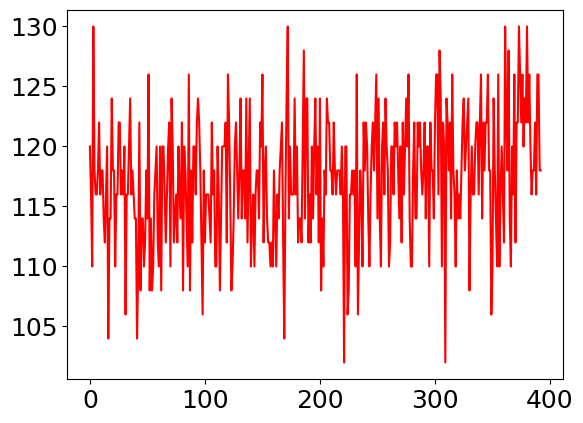

In [ ]:
plt.plot(losses, 'r');

In [405]:
s, lp = simulate(model, istate, subkey, N_ADD)

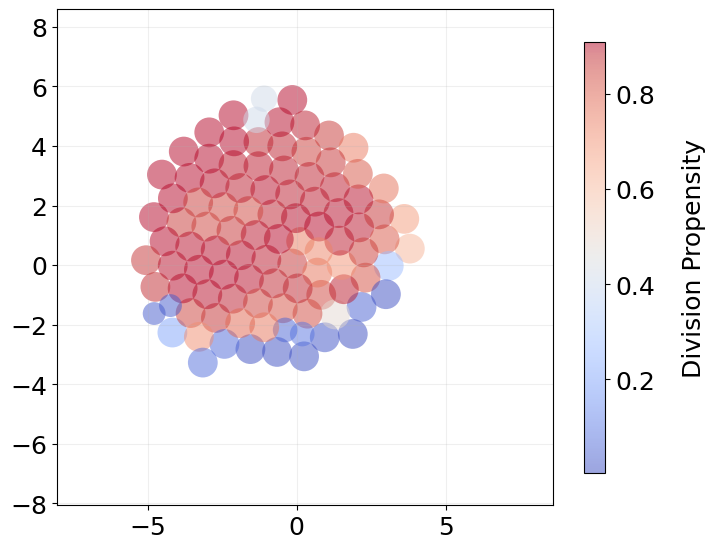

In [406]:
draw_circles_divrate(s, grid=True);

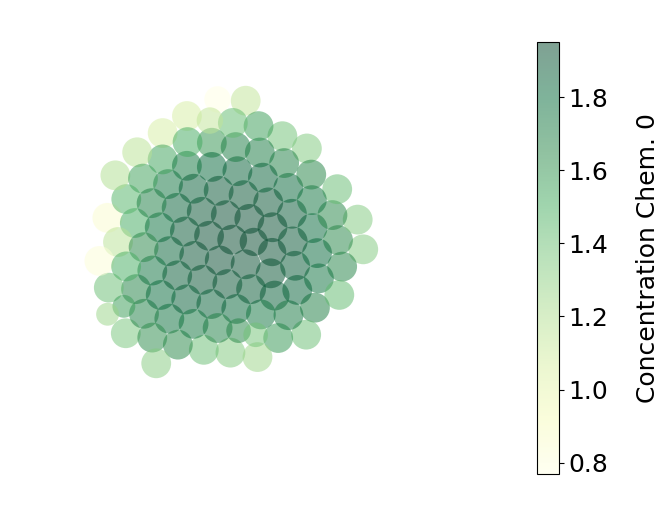

In [407]:
draw_circles_chem(s, 0);

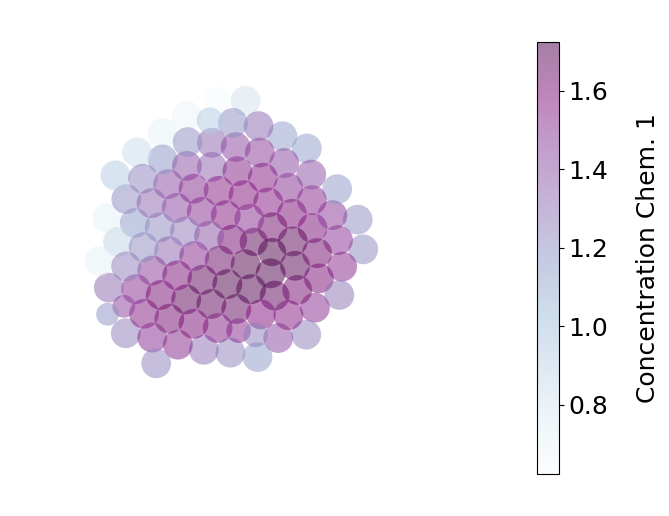

In [410]:
draw_circles_chem(s, 1);

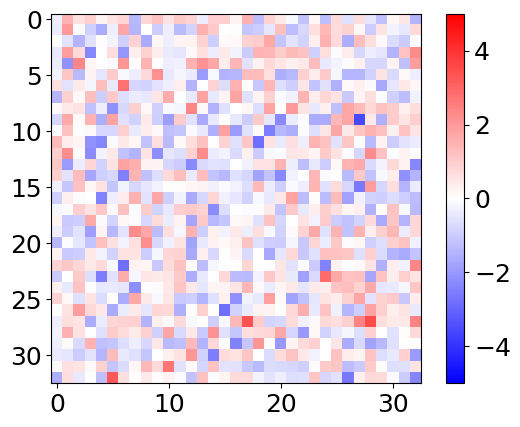

In [411]:
plt.imshow(model[-1].interaction_matrix, cmap='bwr', vmin=-5, vmax=5)
plt.colorbar();